In [401]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import accuracy_score, confusion_matrix,silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
import scipy.cluster.hierarchy as shc

In [169]:
#Import the datasets 

bbc_train = pd.read_csv("/home/pao/Documents/Masters/BBC News Train.csv")
bbc_test = pd.read_csv("/home/pao/Documents/Masters/BBC News Test.csv")

display(bbc_train)
display(bbc_test)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


## Exploratory analysis

**Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)**

In this section, I will look at the data and see if there are any obvious issues that need to be fixed - such as NA values or an unbalanced distribution of number of articles by category. 

Once the data looks good, I'll preprocess by using vectorization techniques and dimensionality reduction. This step is crucial for the models to perform well. 

In [189]:
#Check for NAs 
bbc_train.isna().sum()

#Basic stats
print('Total Articles: ', len(bbc_train.index))
print('Total Categories: ', len(bbc_train.Category.unique()))
print('Categories: ', np.unique(bbc_train.Category))

Total Articles:  1490
Total Categories:  5
Categories:  ['business' 'entertainment' 'politics' 'sport' 'tech']


Text(0.5, 1.0, 'Number of Articles by Category')

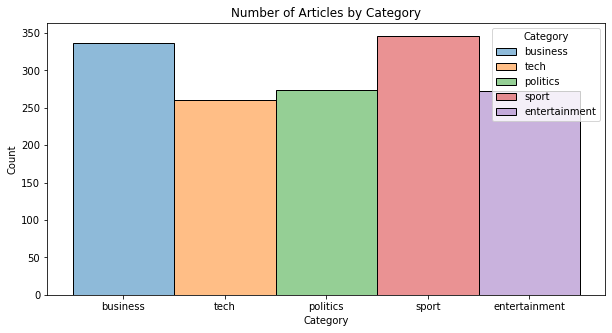

In [207]:
#look at the number of observations for each label category to assess for balance
plt.figure(figsize=(10,5))
cat_count = sns.histplot(data=bbc_train, x='Category', hue='Category',legend=True)
plt.title('Number of Articles by Category')


In [171]:
#let's look at word count per entry and the distribution of word count per category.
bbc_train['Word_count'] = [ len(text) for text in bbc_train.Text ]
bbc_train


,ArticleId,Text,Category,Word_count
0,1833,worldcom ex-boss launches defence lawyers defe...,business,1866
1,154,german business confidence slides german busin...,business,2016
2,1101,bbc poll indicates economic gloom citizens in ...,business,3104
3,1976,lifestyle governs mobile choice faster bett...,tech,3618
4,917,enron bosses in $168m payout eighteen former e...,business,2190
...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,1266
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,3111
1487,1590,weak dollar hits reuters revenues at media gro...,business,1370
1488,1587,apple ipod family expands market apple has exp...,tech,3242


/tmp/ipykernel_76283/2901098454.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  dist = sns.violinplot(data = bbc_train, x='Category', y='Word_count',palette = "pastel" )


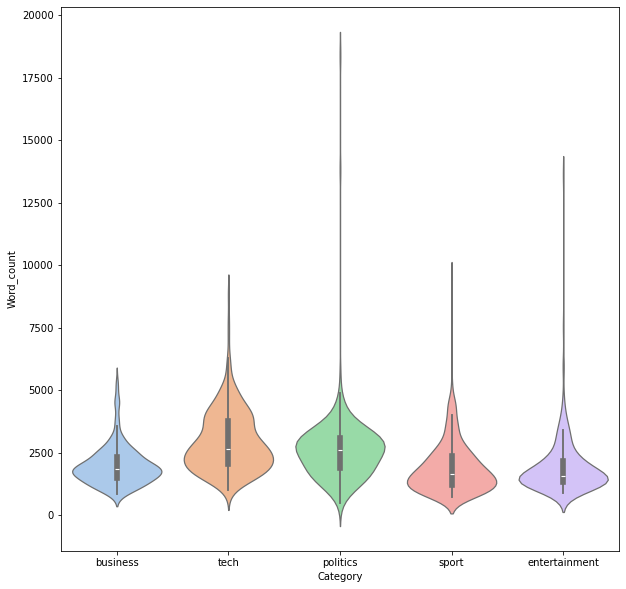

In [183]:
#Graphing the distribution of word count for each article by category
plt.figure(figsize=(10,10))
dist = sns.violinplot(data = bbc_train, x='Category', y='Word_count',palette = "pastel" )

In [208]:
#I want to have numeric labels for the category, so I will factorize 

bbc_train['Categ_num'] = bbc_train['Category'].factorize()[0]
num_true_labels = bbc_train.Categ_num


### Pre-Processing the Data

To move forward with the models, we need to have numeric data. In the pre-processing stage of the data cleaning, I will use different techniques to vectorize the data and extract a numerical value that is representative of some property(s) of the text content. 

A common technique is to count the number of words in the text and turn it into a matrix where the rows are each document and the columns are each word that occurred in the document. 

Another technique is to get a 'Term Frequency' where the number of times a word appears in a document is divided by the total word count of the document. The idea here is that the frequency of a word is tied to the message in the text and so, a higher frequency of a word is an indicator that the text is likely about that topic. 

I want to extract the word counts and TF-IDF values for each word in every document. Sklearn has a library for TfidfVectorization I will use as well as CountVectorizer. On the TfidfVec documentation, I found that I can change the parameters to get different properties in my resulting matrix. I want to explore how changing these can affect the models later on. I will make two vectorized matrices with different parameters for each: TfidfVect and CountVect

The parameters I will be passing will be Sublinear scaling (log) and stop words:
- The default parameters will be used in '_def' vector objects and
- The restrictive parameters will be used in '_rstrct' vector objects (sublinear_tf=True, stop_words=[list])




In [240]:
#Let's start with the default and explore the properties before making the restricted vectorized matrix

tfidf_def = TfidfVectorizer()
tfidf_mat_def = tfidf_def.fit_transform(bbc_train.Text).toarray()
words_def = tfidf_def.get_feature_names_out()

display(words_def[:30])

array(['00', '000', '0001', '000bn', '000m', '000th', '001', '001and',
       '001st', '0051', '007', '01', '0100', '0130', '028', '03', '033',
       '04', '0400', '041', '04bn', '04secs', '05', '050', '050505',
       '0530', '0530gmt', '056', '05bn', '05m'], dtype=object)

In [241]:
#It seems like there are 'words' that are really just numbers. I don't want to include these in the dataset
#to remove them, I'll make a list of them and pass it as a parameter to the bbc_train_def model.

noNum_words = [col for col in words_def if any(char.isdigit() for char in col)]
#display(noNum_words[:30])  #works

#create new vectorized matrix without numeric 'words'
tfidf_def = TfidfVectorizer(stop_words=noNum_words)
tfidf_mat_def = tfidf_def.fit_transform(bbc_train.Text).toarray()
display(tfidf_def.get_feature_names_out())  #nice, no more words that have numbers are included.

array(['aa', 'aaa', 'aaas', ..., 'zurich', 'zutons', 'zvonareva'],
      dtype=object)

In [242]:
#let's make the count vector matrix default
countVec_def = CountVectorizer(stop_words=noNum_words)
countVec_matrix_def = countVec_def.fit_transform(bbc_train.Text).toarray()

display(countVec_def.get_feature_names_out())

array(['aa', 'aaa', 'aaas', ..., 'zurich', 'zutons', 'zvonareva'],
      dtype=object)

In [259]:
#Lastly, the restricted parameter vectorized matrices
#For stop words, I will create a list of words that include the words in the 'english' list of stop words
#and the noNum_words so that the resulting list of words does not have either of those. 

#get the words from the enlgish stop words list
temp_rstrct = TfidfVectorizer(stop_words='english')
english_list = list(temp_rstrct.get_stop_words())
#display(english_list) #works
english_list = english_list + noNum_words
#display(english_list) #works


tfidf_rstrct = TfidfVectorizer(sublinear_tf=True, stop_words=english_list)
tfidf_mat_rstrct = tfidf_rstrct.fit_transform(bbc_train.Text).toarray()

countVec_rstrct = CountVectorizer(stop_words=english_list)
countVec_matrix_rstrct = countVec_rstrct.fit_transform(bbc_train.Text).toarray()
#display(countVec_rstrct.get_feature_names_out()) #works!


/home/pao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


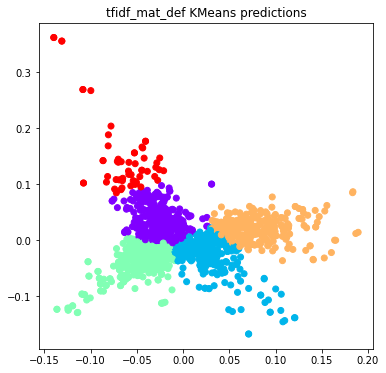

/home/pao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


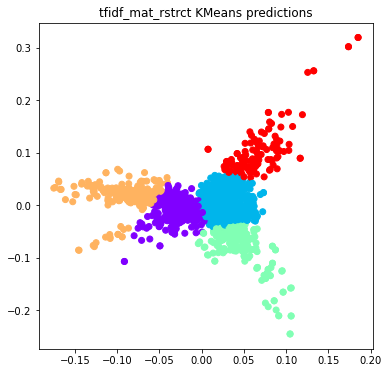

In [279]:
#Let's preprocess the data with PCA and graph the K-Means clustering to visualize what it looks like

Vec_mat_tfidf = [tfidf_mat_def,tfidf_mat_rstrct]
pca_mat_tfidf = []

for matrix in Vec_mat_tfidf:
    #Scale data
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(matrix)
    #normalize data
    train_normed = normalize(train_scaled)
    train_normed = pd.DataFrame(train_normed)
    pca = PCA(n_components = 2)
    train_pca = pca.fit_transform(train_normed)
    train_pca = pd.DataFrame(train_pca)
    pca_mat_tfidf.append(train_pca)

# Visualizing the clustering
plt.figure(figsize =(6, 6))
temp_pca=pca_mat_tfidf[0]
plt.scatter(temp_pca[0],temp_pca[1],
           c = KMeans(n_clusters=5).fit_predict(temp_pca), cmap ='rainbow')
plt.title("tfidf_mat_def KMeans predictions")
plt.show()

# Visualizing the clustering
plt.figure(figsize =(6, 6))
temp_pca=pca_mat_tfidf[1]
plt.scatter(temp_pca[0],temp_pca[1],
           c = KMeans(n_clusters=5).fit_predict(temp_pca), cmap ='rainbow')
plt.title("tfidf_mat_rstrct KMeans predictions")
plt.show()


####---- SAME GRAPHS BUT AGGLOMERATIVE CLUSTERING FOR MY OWN FUN --- 

#plt.figure(figsize =(6, 6))
#temp_pca=pca_mat_tfidf[0]
#plt.scatter(temp_pca[0],temp_pca[1],
#           c = AgglomerativeClustering(n_clusters=5).fit_predict(temp_pca), cmap ='rainbow')
#plt.title("tfidf_mat_def AgglomerativeClustering predictions")
#plt.show()


#plt.figure(figsize =(6, 6))
#temp_pca=pca_mat_tfidf[1]
#plt.scatter(temp_pca[0],temp_pca[1],
#           c = AgglomerativeClustering(n_clusters=5).fit_predict(temp_pca), cmap ='rainbow')
#plt.title("tfidf_mat_rstrct AgglomerativeClustering predictions")
#plt.show()

/home/pao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


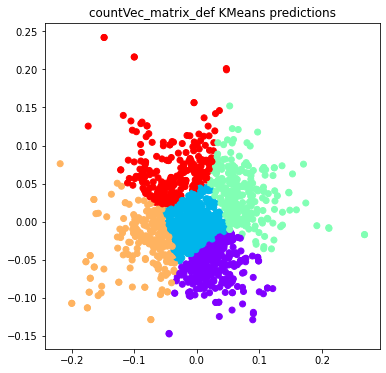

/home/pao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


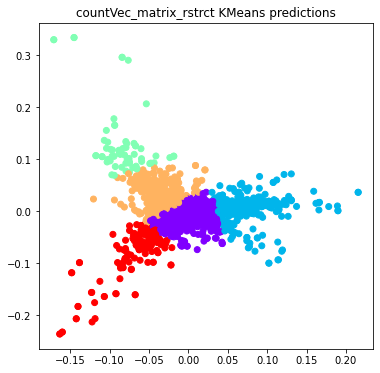

In [280]:
#Let's preprocess the data with PCA and graph the K-Means clustering to visualize what it looks like

Vec_mat_count = [countVec_matrix_def,countVec_matrix_rstrct]
pca_mat_count = []

for matrix in Vec_mat_count:
    #Scale data
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(matrix)
    #normalize data
    train_normed = normalize(train_scaled)
    train_normed = pd.DataFrame(train_normed)
    pca = PCA(n_components = 2)
    train_pca = pca.fit_transform(train_normed)
    train_pca = pd.DataFrame(train_pca)
    pca_mat_count.append(train_pca)

# Visualizing the clustering
plt.figure(figsize =(6, 6))
temp_pca=pca_mat_count[0]
plt.scatter(temp_pca[0],temp_pca[1],
           c = KMeans(n_clusters=5).fit_predict(temp_pca), cmap ='rainbow')
plt.title("countVec_matrix_def KMeans predictions")
plt.show()

# Visualizing the clustering
plt.figure(figsize =(6, 6))
temp_pca=pca_mat_count[1]
plt.scatter(temp_pca[0],temp_pca[1],
           c = KMeans(n_clusters=5).fit_predict(temp_pca), cmap ='rainbow')
plt.title("countVec_matrix_rstrct KMeans predictions")
plt.show()



####---- SAME GRAPHS BUT AGGLOMERATIVE CLUSTERING FOR MY OWN FUN --- 

#plt.figure(figsize =(6, 6))
#temp_pca=pca_mat_count[0]
#plt.scatter(temp_pca[0],temp_pca[1],
#           c = AgglomerativeClustering(n_clusters=5).fit_predict(temp_pca), cmap ='rainbow')
#plt.title("countVec_matrix_def AgglomerativeClustering predictions")
#plt.show()

#plt.figure(figsize =(6, 6))
#temp_pca=pca_mat_count[1]
#plt.scatter(temp_pca[0],temp_pca[1],
#           c = AgglomerativeClustering(n_clusters=5).fit_predict(temp_pca), cmap ='rainbow')
#plt.title("countVec_matrix_rstrct AgglomerativeClustering predictions")
#plt.show()



These cluster graphs were cool to look at and it seems that each category relatively has their own section or distinct grouping/area so the models might work well!

However, I don't think we need to use all 4 vectorized matrices, so I'll stick with the TF-IDF Vectorization matrices. I feel with this approach of extracting latent factors will be more effective because TFiDF provides a frequency that is proportional to the total count of words in the text, and tends to be more robust than simple word count. 

Moving forward, I'll compare the two TFiDF vectorized matrices on every model to observe how the parameters used to vectorize the matrices affects the models. 

## Building and training models

For the models, I will use the TFiDF vectorized matrices and NOT the Count vectorized matrices. This is because with TFiDF, the extracted characteristics are more insightful about the topic of the text simply because the frequency of each word is related to the relevance to the topic. The higher frequency, the more relevant the word is. 

Of course, from this, we have to make sure we remove any words that are not actually telling us something about the text -- words like "the", "a", "he", "they", etc. To remove these words, I used the "stop_words" parameter on both of the vectorized matrices. 

I will create a dataframe with the **RESULTS** for reviewing and comparing the models at the end. 

The models will have different parameters, and those along with the accuracy score for the model will be added to the data frame. 


In [294]:
#Let's bring in the function from week 2 that would iterate through all permutations of label assignment
#to see which assignment of labels resulted in the highest accuracy. 

import itertools

def label_permute_compare(true_labels,yp,n=4):
    unique_labels = np.unique(true_labels) #find unique labels

    best_accuracy = 0
    best_permutation = None
    
    #Go through each possible permutation of labels to see which one has best accuracy
    for permuted_labels in itertools.permutations(unique_labels):
        # Map the permutation to a dictionary for easy replacement
        label_map = {label: permuted_labels[i] for i, label in enumerate(unique_labels)}
        
        # Permute the predicted labels based on the current mapping permutation
        permuted_yp = [label_map[label] for label in yp]
        
        # Calculate accuracy for this permutation
        accuracy = accuracy_score(true_labels, permuted_yp)
        
        # Update the best accuracy and permutation if this one is better
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_permutation = permuted_labels
    
    return best_permutation, best_accuracy


In [393]:
#This data frame will hold all the values needed to compare the models 
Model_comparison_def = pd.DataFrame(columns=['Model','Label_order','Accuracy_score'])
Model_comparison_rstrct = pd.DataFrame(columns=['Model','Label_order','Accuracy_score'])


In [391]:
#I'm going to use Truncated SVD to reduce dimensionality and then pass this into the Clustering Models.

tfidf_mat_def = tfidf_def.fit_transform(bbc_train.Text)
svd_def = TruncatedSVD(n_components= 5)
svd_def_mod= svd_def.fit_transform(tfidf_mat_def)
#svd_def_comp = svd_def.components_


tfidf_mat_rstrct = tfidf_rstrct.fit_transform(bbc_train.Text)
svd_rstrct = TruncatedSVD(n_components=5)
svd_rstrct_mod = svd_rstrct.fit_transform(tfidf_mat_rstrct)
#svd_rstrct_comp = svd_rstrct.components_



In [394]:
### With default vectorized Matrix

#### Model 1 = Cosine/Average
Model_1_def = AgglomerativeClustering(n_clusters=5,metric='cosine',linkage='average').fit(svd_def_mod)
#print(accuracy_score(num_true_labels,Model_1.labels_))
label_perm, acc_score = label_permute_compare(num_true_labels,Model_1_def.labels_)
#print(label_perm, acc_score)
Model_comparison_def.loc[len(Model_comparison_def.index)] = ['Cluster (SVD) - Cos/Avg',label_perm, acc_score ]


### Model 2 = Cosine/Complete
Model_2_def = AgglomerativeClustering(n_clusters=5,metric='cosine',linkage='complete').fit(svd_def_mod)
#print(accuracy_score(num_true_labels,Model_2.labels_))
label_perm, acc_score = label_permute_compare(num_true_labels,Model_2_def.labels_)
#print(label_perm, acc_score)
Model_comparison_def.loc[len(Model_comparison_def.index)] = ['Cluster (SVD) - Cos/Com',label_perm, acc_score ]


### Model 3 = Euclidean/Ward
Model_3 = AgglomerativeClustering(n_clusters=5,metric='euclidean',linkage='ward').fit(svd_def_mod)
#print(accuracy_score(num_true_labels,Model_3.labels_))
label_perm, acc_score = label_permute_compare(num_true_labels,Model_3.labels_)
#print(label_perm, acc_score)
Model_comparison_def.loc[len(Model_comparison_def.index)] = ['Cluster (SVD) - Euc/Ward',label_perm, acc_score ]


### Model_4 = Euclidean/Average
Model_4 = AgglomerativeClustering(n_clusters=5,metric='euclidean',linkage='average').fit(svd_def_mod)
#print(accuracy_score(num_true_labels,Model_4.labels_))
label_perm, acc_score = label_permute_compare(num_true_labels,Model_4.labels_)
#print(label_perm, acc_score)
Model_comparison_def.loc[len(Model_comparison_def.index)] = ['Cluster (SVD) - Euc/Avg',label_perm, acc_score ]


In [395]:
### With Rstrct vectorized matrix

#### Model 1 = Cosine/Average
Model_1_def = AgglomerativeClustering(n_clusters=5,metric='cosine',linkage='average').fit(svd_rstrct_mod)
label_perm, acc_score = label_permute_compare(num_true_labels,Model_1_def.labels_)
Model_comparison_rstrct.loc[len(Model_comparison_rstrct.index)] = ['Cluster (SVD) - Cos/Avg',label_perm, acc_score ]


### Model 2 = Cosine/Complete
Model_2_def = AgglomerativeClustering(n_clusters=5,metric='cosine',linkage='complete').fit(svd_rstrct_mod)
label_perm, acc_score = label_permute_compare(num_true_labels,Model_2_def.labels_)
Model_comparison_rstrct.loc[len(Model_comparison_rstrct.index)] = ['Cluster (SVD) - Cos/Com',label_perm, acc_score ]


### Model 3 = Euclidean/Ward
Model_3 = AgglomerativeClustering(n_clusters=5,metric='euclidean',linkage='ward').fit(svd_rstrct_mod)
label_perm, acc_score = label_permute_compare(num_true_labels,Model_3.labels_)
Model_comparison_rstrct.loc[len(Model_comparison_rstrct.index)] = ['Cluster (SVD) - Euc/Ward',label_perm, acc_score ]


### Model_4 = Euclidean/Average
Model_4 = AgglomerativeClustering(n_clusters=5,metric='euclidean',linkage='average').fit(svd_rstrct_mod)
label_perm, acc_score = label_permute_compare(num_true_labels,Model_4.labels_)
Model_comparison_rstrct.loc[len(Model_comparison_rstrct.index)] = ['Cluster (SVD) - Euc/Avg',label_perm, acc_score ]


In [397]:
display(Model_comparison_def)
display(Model_comparison_rstrct)


,Model,Label_order,Accuracy_score
0,Cluster (SVD) - Cos/Avg,"(3, 2, 0, 4, 1)",0.779866
1,Cluster (SVD) - Cos/Com,"(0, 4, 3, 2, 1)",0.824832
2,Cluster (SVD) - Euc/Ward,"(2, 0, 4, 1, 3)",0.875839
3,Cluster (SVD) - Euc/Avg,"(3, 2, 4, 0, 1)",0.432886


,Model,Label_order,Accuracy_score
0,Cluster (SVD) - Cos/Avg,"(4, 1, 3, 0, 2)",0.954362
1,Cluster (SVD) - Cos/Com,"(2, 4, 1, 0, 3)",0.917450
2,Cluster (SVD) - Euc/Ward,"(4, 0, 2, 3, 1)",0.932215
3,Cluster (SVD) - Euc/Avg,"(2, 0, 3, 4, 1)",0.796644


In [398]:
#Let's look at the NonNegative Matrix Factorization Model

#Default vectorized data, Frobenius beta loss
nmf_def_frob = NMF(n_components = 5, 
           init = 'nndsvd', 
           solver = 'cd', 
           beta_loss ='frobenius', 
           random_state =10)
nmf_def_Fbmod = nmf_def_frob.fit_transform(tfidf_mat_def) 
nmf_def_Fbmod_comp = nmf_def_frob.components_
predicted_labels = np.argmax(nmf_def_Fbmod, axis=1) 
label_perm, acc_score = label_permute_compare(num_true_labels,predicted_labels)
Model_comparison_def.loc[len(Model_comparison_def.index)] = ['NMF - Frobenius',label_perm, acc_score ]



#Default vectorized data, KL beta loss
nmf_def_KL = NMF(n_components = 5, 
           init = 'nndsvd', 
            solver = 'mu', 
            beta_loss ='kullback-leibler',  
           random_state =10)
nmf_def_KLmod= nmf_def_KL.fit_transform(tfidf_mat_def) 
nmf_def_KLmod_comp = nmf_def_KL.components_
predicted_labels = np.argmax(nmf_def_KLmod, axis=1) 
label_perm, acc_score = label_permute_compare(num_true_labels,predicted_labels)
Model_comparison_def.loc[len(Model_comparison_def.index)] = ['NMF - KL',label_perm, acc_score ]



#Restricted vectorized data, Frobenius beta loss
nmf_rstrct_frob = NMF(n_components = 5, 
           init = 'nndsvd', 
           solver = 'cd', 
           beta_loss ='frobenius', 
           random_state =10)
nmf_rstrct_Fbmod = nmf_rstrct_frob.fit_transform(tfidf_mat_rstrct) 
nmf_rstrct_Fbmod_comp = nmf_rstrct_frob.components_
predicted_labels = np.argmax(nmf_rstrct_Fbmod, axis=1) 
label_perm, acc_score = label_permute_compare(num_true_labels,predicted_labels)
Model_comparison_rstrct.loc[len(Model_comparison_rstrct.index)] = ['NMF - Frobenius',label_perm, acc_score ]


#Restricted vectorized data, KL beta loss
nmf_rstrct_KL = NMF(n_components = 5, 
           init = 'nndsvd', 
            solver = 'mu', 
            beta_loss ='kullback-leibler',  
           random_state =10)
nmf_rstrct_KLmod = nmf_rstrct_KL.fit_transform(tfidf_mat_rstrct) 
nmf_rstrct_KLmod_comp = nmf_rstrct_KL.components_
predicted_labels = np.argmax(nmf_rstrct_KLmod, axis=1) 
label_perm, acc_score = label_permute_compare(num_true_labels,predicted_labels)
Model_comparison_rstrct.loc[len(Model_comparison_rstrct.index)] = ['NMF - KL',label_perm, acc_score ]


/home/pao/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(
/home/pao/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


In [399]:
display(Model_comparison_def)
display(Model_comparison_rstrct)

,Model,Label_order,Accuracy_score
0,Cluster (SVD) - Cos/Avg,"(3, 2, 0, 4, 1)",0.779866
1,Cluster (SVD) - Cos/Com,"(0, 4, 3, 2, 1)",0.824832
2,Cluster (SVD) - Euc/Ward,"(2, 0, 4, 1, 3)",0.875839
3,Cluster (SVD) - Euc/Avg,"(3, 2, 4, 0, 1)",0.432886
4,NMF - Frobenius,"(0, 2, 3, 4, 1)",0.874497
5,NMF - KL,"(0, 2, 3, 4, 1)",0.904698


,Model,Label_order,Accuracy_score
0,Cluster (SVD) - Cos/Avg,"(4, 1, 3, 0, 2)",0.954362
1,Cluster (SVD) - Cos/Com,"(2, 4, 1, 0, 3)",0.917450
2,Cluster (SVD) - Euc/Ward,"(4, 0, 2, 3, 1)",0.932215
3,Cluster (SVD) - Euc/Avg,"(2, 0, 3, 4, 1)",0.796644
4,NMF - Frobenius,"(2, 3, 1, 4, 0)",0.941611
5,NMF - KL,"(2, 3, 1, 4, 0)",0.921477


## Compare with supervised learning 

Use the following steps to guide your work:

1) Pick and train a supervised learning method(s) and compare the results (train and test performance)
2) Discuss comparison with the unsupervised approach. You may try changing the train data size (e.g., Include only 10%, 20%, 50% of labels, and observe train/test performance changes). Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?

In [403]:
#I'll be using Decision Tree classifier to compare to my models 

#Default TFiDF Vec
X_train_def, X_test_def, y_train_def, y_test_def = train_test_split(tfidf_mat_def, labels, test_size=0.2, random_state=10)
tree_class_def = DecisionTreeClassifier(random_state=10)
tree_class_def.fit(X_train_def, y_train_def)
y_pred_def = tree_class_def.predict(X_test_def)


#Restricted TFiDF Vec 
X_train_rstrct, X_test_rstrct, y_train_rstrct, y_test_rstrct = train_test_split(tfidf_mat_rstrct, labels, test_size=0.20, random_state=10)
tree_class_rstrct = DecisionTreeClassifier(random_state=10)
tree_class_rstrct.fit(X_train_rstrct, y_train_rstrct)
y_pred_rstrct = tree_class_rstrct.predict(X_test_rstrct)



In [408]:
accuracy_def = accuracy_score(y_test_def, y_pred_def)
#print("Decision Tree Def Acc: ", accuracy_def)
label_perm, acc_score = label_permute_compare(y_test_def,y_pred_def)
#print(label_perm, acc_score )
Model_comparison_def.loc[len(Model_comparison_def.index)] = ['Decision Tree',label_perm, acc_score ]


accuracy_rstrct = accuracy_score(y_test_rstrct, y_pred_rstrct)
#print("Decision Tree Rstrct Acc: ", accuracy_rstrct)
label_perm, acc_score = label_permute_compare(y_test_rstrct,y_pred_rstrct)
#print(label_perm, acc_score )
Model_comparison_rstrct.loc[len(Model_comparison_rstrct.index)] = ['Decision Tree',label_perm, acc_score ]


## Results

In [409]:
Model_comparison_def

,Model,Label_order,Accuracy_score
0,Cluster (SVD) - Cos/Avg,"(3, 2, 0, 4, 1)",0.779866
1,Cluster (SVD) - Cos/Com,"(0, 4, 3, 2, 1)",0.824832
2,Cluster (SVD) - Euc/Ward,"(2, 0, 4, 1, 3)",0.875839
3,Cluster (SVD) - Euc/Avg,"(3, 2, 4, 0, 1)",0.432886
4,NMF - Frobenius,"(0, 2, 3, 4, 1)",0.874497
5,NMF - KL,"(0, 2, 3, 4, 1)",0.904698
6,Decision Tree,"(0, 1, 2, 3, 4)",0.791946


In [410]:
Model_comparison_rstrct

,Model,Label_order,Accuracy_score
0,Cluster (SVD) - Cos/Avg,"(4, 1, 3, 0, 2)",0.954362
1,Cluster (SVD) - Cos/Com,"(2, 4, 1, 0, 3)",0.917450
2,Cluster (SVD) - Euc/Ward,"(4, 0, 2, 3, 1)",0.932215
3,Cluster (SVD) - Euc/Avg,"(2, 0, 3, 4, 1)",0.796644
4,NMF - Frobenius,"(2, 3, 1, 4, 0)",0.941611
5,NMF - KL,"(2, 3, 1, 4, 0)",0.921477
6,Decision Tree,"(0, 1, 2, 3, 4)",0.798658


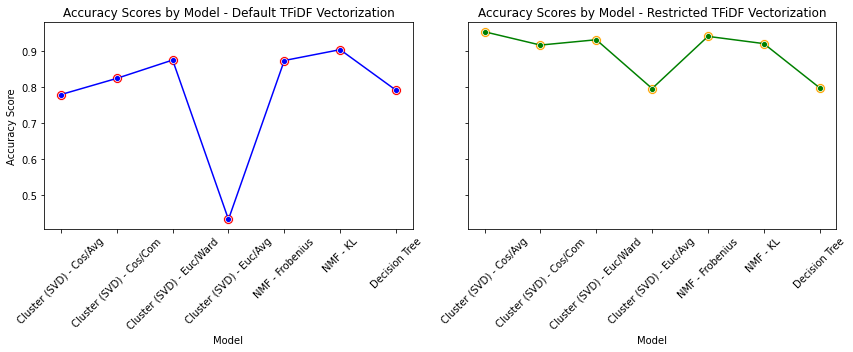

In [417]:

# Set up the matplotlib figure and axes
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # Share Y axis between subplots

# First subplot
sns.lineplot(data=Model_comparison_def, x='Model', y='Accuracy_score', marker='o', linestyle='-', color='blue', ax=axs[0])
sns.scatterplot(data=Model_comparison_def, x='Model', y='Accuracy_score', color='red', s=100, ax=axs[0])
axs[0].set_title('Accuracy Scores by Model - Default TFiDF Vectorization')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Accuracy Score')
axs[0].tick_params(axis='x', rotation=45)



# Second subplot
sns.lineplot(data=Model_comparison_rstrct, x='Model', y='Accuracy_score', marker='o', linestyle='-', color='green', ax=axs[1])
sns.scatterplot(data=Model_comparison_rstrct, x='Model', y='Accuracy_score', color='orange', s=100, ax=axs[1])
axs[1].set_title('Accuracy Scores by Model - Restricted TFiDF Vectorization')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Accuracy Score')
axs[1].tick_params(axis='x', rotation=45)

# Automatically adjust subplot params so that the subplot(s) fits in to the figure area.
plt.tight_layout()

# Show the plot
plt.show()

These graphs show that the models that used the restricted TFiDF vectorized matrix performed better than the TFiDF vectorized matrix that used the default parameters. The Wilcoxon test resulted in a p-value lower than the default alpha set, which suggests that the parameters used in the TFiDF vectorization process result in a statistically significant difference in accuracy scores. 

Pretty cool! 



It looks like the models that used the Restricted TFiDF Vectorized Matrices performed better with higher accuracy. Let's do an F-test to see if there is a statistically significant difference between the two vectorized matrices. 

Since I don't have a large group of model accuracy scores, and I can't guarantee that normality is met, I can't use a t-test, so I'll use a Wilcoxon test. I'll use the default alpha as 0.05 and see if the p-value of the test is significant. 

In [412]:
from scipy.stats import wilcoxon

# Apply Wilcoxon Signed-Rank Test
stat, p_value = wilcoxon(Model_comparison_def.Accuracy_score, Model_comparison_rstrct.Accuracy_score)
print("Wilcoxon Statistic:", stat)
print("P-Value:", p_value)

Wilcoxon Statistic: 0.0
P-Value: 0.015625


## Conclusion

All in all, the model with the highest accuracy score was the Clustering model with metric = 'Cosine' and linkage = 'Average' fitting the TFiDF Vectorized data with a more conservative exclusion of words AFTER perfoming dimensionality reduction through TruncatedSVD method. The second best model was the NonNegative Matrix Factorization model again, on the restricted TFiDF Vectorized data. 